# Health Analytics

## Table of Contents

1. [Problem Statement](#section1)<br>
2. [Importing Packages](#section2)<br>
3. [Loading Data](#section3)<br>
  - 3.1 [Description of the Datasets](#section301)<br>
4. [Data Preprocessing](#section4)<br>
  - 4.1 [Feature Engineering of Train](#section401)<br>
  - 4.2 [Feature Engineering of Test](#section402)<br>
  - 4.3 [Feature Engineering of Patient Profile](#section403)<br>
  - 4.4 [Feature Engineering of Health Camp](#section404)<br>
  - 4.5 [Some More Feature Engineering ](#section405)<br>
5. [Data processing before model building](#section5)<br>
  - 5.1 [Splitting Train data into train and validation](#section501)<br>
  - 5.2 [Extracting Important Features](#section502)<br>
6. [Model building and prediction](#section6)<br>
    - 6.1 [LGBM Classifier](#section601)
    - 6.2 [Final Prediction](#section602)


<a id=section1></a>
# 1. Problem Statement

Congratulations – you have been hired as Chief Data Scientist of MedCamp – a not for profit organization dedicated in making health conditions for working professionals better. MedCamp was started because the founders saw their family suffer due to bad work life balance and neglected health.

MedCamp organizes health camps in several cities with low work life balance. They reach out to working people and ask them to register for these health camps. For those who attend, MedCamp provides them facility to undergo health checks or increase awareness by visiting various stalls (depending on the format of camp).

MedCamp has conducted 65 such events over a period of 4 years and they see a high drop off between “Registration” and Number of people taking tests at the Camps. In last 4 years, they have stored data of ~110,000 registrations they have done.
One of the huge costs in arranging these camps is the amount of inventory you need to carry. If you carry more than required inventory, you incur unnecessarily high costs. On the other hand, if you carry less than required inventory for conducting these medical checks, people end up having bad experience.

**The Process:** MedCamp employees / volunteers reach out to people and drive registrations. During the camp, People who **“ShowUp”** either undergo the medical tests or visit stalls depending on the format of health camp.

**Other things to note:** Since this is a completely voluntary activity for the working professionals, MedCamp usually has little profile information about these people. For a few camps, there was hardware failure, so some information about date and time of registration is lost. MedCamp runs 3 formats of these camps. The first and second format provides people with an instantaneous health score. The third format provides information about several health issues through various awareness stalls. 

**Favorable outcome:** For the first 2 formats, a favourable outcome is defined as getting a health_score, while in the third format it is defined as visiting at least a stall. You need to predict the chances (probability) of having a favourable outcome.


<a id=section2></a>
# 2. Importing Packages

In [1]:
import numpy as np                     

import pandas as pd

# To suppress pandas warnings.
pd.set_option('mode.chained_assignment', None)          

pd.get_option("display.max_rows",10000)

# To display every column of the dataset in head()
pd.options.display.max_columns = 100               

import warnings
warnings.filterwarnings('ignore')     

In [2]:
import seaborn as sns 

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *

import gc

from tqdm import tqdm, tqdm_notebook

<a id=section3></a>

# 3. Loading Data

**Train.csv** – File containing registration details for all the test camps. This includes Patient_ID, Health_Camp_ID, 
Registration_Date and a few anonymized variables as on registration date.

**First_Health_Camp_Attended.csv** – This file contains details about people who attended health camp of first format. This includes Donation (amount) & Health_Score of the person.

**Second_Health_Camp_Attended.csv** - This file contains details about people who attended health camp of second format. This includes Health_Score of the person.

**Third_Health_Camp_Attended.csv** - This file contains details about people who attended health camp of third format. This includes Number_of_stall_visited & Last_Stall_Visited_Number.

**Patient_Profile.csv** – This file contains Patient profile details like Patient_ID, Online_Follower, Social media details, Income, Education, Age, First_Interaction_Date, City_Type and Employer_Category

**Health_Camp_Detail.csv** – File containing Health_Camp_Id, Camp_Start_Date, Camp_End_Date and Category details of each camp.

**Test.csv** – File containing registration details for all the test camps. This includes Patient_ID, Health_Camp_ID, Registration_Date and a few anonymized variables as on registration date.


In [3]:
Train = pd.read_csv('data/Train.csv')

First_Health_Camp_Attended = pd.read_csv('data/First_Health_Camp_Attended.csv')
Second_Health_Camp_Attended = pd.read_csv('data/Second_Health_Camp_Attended.csv')
Third_Health_Camp_Attended = pd.read_csv('data/Third_Health_Camp_Attended.csv')

Patient_Profile = pd.read_csv('data/Patient_Profile.csv')
Health_Camp_Detail = pd.read_csv('data/Health_Camp_Detail.csv')

Test = pd.read_csv('data/Test.csv')

#sub = pd.read_csv('Data/sample_submmission.csv')

<a id=section301></a>
## 3.1 Description of the Datasets

### a. Shape

In [4]:
#shape of data
Train.shape

(75278, 8)

In [5]:
First_Health_Camp_Attended.shape, Second_Health_Camp_Attended.shape, Third_Health_Camp_Attended.shape

((6218, 5), (7819, 3), (6515, 4))

In [6]:
Patient_Profile.shape, Health_Camp_Detail.shape 

((37633, 11), (65, 6))

In [7]:
Test.shape

(35249, 8)

### b. Description




#### 1. Train

**Patient_ID:**	Unique Identifier for each patient. This ID is not sequential in nature and can not be used in modeling

**Health_Camp_ID:**	Unique Identifier for each camp. This ID is not sequential in nature and can not be used in modeling

**Registration_Date:**	Date of Registration of the patient for the health camp

**Var1 - Var5:**	Anonymized variables captured at time of registrations. These are numerical in nature and can only have discrete values


In [8]:
Train.sample(5)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
52771,518965,6546,11-Jan-04,0,0,0,0,0
34929,495711,6555,25-Jul-05,0,0,0,0,0
35293,525750,6570,18-Jun-05,0,0,0,0,0
46650,495320,6532,08-Jul-05,3,0,0,0,1
29138,513479,6536,17-Feb-05,0,0,0,0,0


In [9]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75278 entries, 0 to 75277
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient_ID         75278 non-null  int64 
 1   Health_Camp_ID     75278 non-null  int64 
 2   Registration_Date  74944 non-null  object
 3   Var1               75278 non-null  int64 
 4   Var2               75278 non-null  int64 
 5   Var3               75278 non-null  int64 
 6   Var4               75278 non-null  int64 
 7   Var5               75278 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 4.6+ MB


In [10]:
Train[['Var1', 'Var2', 'Var3', 'Var4']].describe()

,Var1,Var2,Var3,Var4
count,75278.000000,75278.000000,75278.000000,75278.000000
mean,0.796156,0.238556,0.000385,0.022424
std,7.626687,3.769594,0.019624,0.199570
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,288.000000,156.000000,1.000000,4.000000


#### 2.  First_Health_Camp_Attended

Patient_ID:	Unique Identifier for each patient. This ID is not sequential in nature and can not be used in modeling

Health_Camp_ID:	Unique Identifier for each camp. This ID is not sequential in nature and can not be used in modeling

Donation:	Amount of donation received at the camp

Health_Score:	Health Score as detected by the test at the camp


In [11]:
First_Health_Camp_Attended.sample(5)

,Patient_ID,Health_Camp_ID,Donation,Health_Score,Unnamed: 4
5317,503124,6532,20,0.530534,NaN
3934,527159,6575,50,0.666667,NaN
353,510493,6538,20,0.091054,NaN
1740,513551,6540,30,0.714286,NaN
1755,515405,6540,30,0.357143,NaN


In [12]:
First_Health_Camp_Attended.drop('Unnamed: 4', inplace=True, axis = 1)

In [13]:
First_Health_Camp_Attended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6218 entries, 0 to 6217
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patient_ID      6218 non-null   int64  
 1   Health_Camp_ID  6218 non-null   int64  
 2   Donation        6218 non-null   int64  
 3   Health_Score    6218 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 194.4 KB


In [14]:
First_Health_Camp_Attended[['Donation', 'Health_Score']].describe()

,Donation,Health_Score
count,6218.000000,6218.000000
mean,32.587649,0.517668
std,24.501676,0.289211
min,10.000000,0.001667
25%,20.000000,0.263094
50%,30.000000,0.529706
75%,40.000000,0.771429
max,330.000000,1.000000


#### 3.  Second_Health_Camp_Attended

Patient_ID:	Unique Identifier for each patient. This ID is not sequential in nature and can not be used in modeling

Health_Camp_ID:	Unique Identifier for each camp. This ID is not sequential in nature and can not be used in modeling

Health_Score:	Health Score as detected by the test at the camp


In [15]:
Second_Health_Camp_Attended.sample(5)

,Patient_ID,Health_Camp_ID,Health Score
1473,496560,6523,0.822283
2240,494076,6555,0.864748
4528,506602,6529,0.338359
6152,520252,6555,0.341007
3148,490617,6534,0.402054


In [16]:
Second_Health_Camp_Attended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7819 entries, 0 to 7818
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patient_ID      7819 non-null   int64  
 1   Health_Camp_ID  7819 non-null   int64  
 2   Health Score    7819 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 183.4 KB


In [17]:
Second_Health_Camp_Attended['Health Score'].describe()

count    7819.000000
mean        0.554178
std         0.249378
min         0.058993
25%         0.389626
50%         0.518797
75%         0.762724
max         1.000000
Name: Health Score, dtype: float64

#### 4.  Third_Health_Camp_Attended

Patient_ID:	Unique Identifier for each patient. This ID is not sequential in nature and can not be used in modeling

Health_Camp_ID:	Unique Identifier for each camp. This ID is not sequential in nature and can not be used in modeling

Number_of_stall_visited:	Number of stalls visited at the camp

Last_Stall_Visited_Number:	Stall number of the stall which the patient visited last. For example, if a person visited only 2 stalls say number 1 and number 7. Then, this variable would be 7.


In [18]:
Third_Health_Camp_Attended.sample(5)

,Patient_ID,Health_Camp_ID,Number_of_stall_visited,Last_Stall_Visited_Number
5855,488639,6528,2,6
3954,526575,6528,2,2
110,492396,6541,2,1
4948,500324,6578,1,3
5370,501636,6527,2,2


In [19]:
Third_Health_Camp_Attended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6515 entries, 0 to 6514
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Patient_ID                 6515 non-null   int64
 1   Health_Camp_ID             6515 non-null   int64
 2   Number_of_stall_visited    6515 non-null   int64
 3   Last_Stall_Visited_Number  6515 non-null   int64
dtypes: int64(4)
memory usage: 203.7 KB


In [20]:
Third_Health_Camp_Attended[['Number_of_stall_visited', 'Last_Stall_Visited_Number']].describe()

,Number_of_stall_visited,Last_Stall_Visited_Number
count,6515.000000,6515.000000
mean,2.923254,2.404144
std,1.688500,1.469623
min,0.000000,0.000000
25%,1.000000,1.000000
50%,3.000000,2.000000
75%,4.000000,3.000000
max,7.000000,7.000000


#### 5. Patient_Profile

Patient_ID:	Unique Identifier for each patient. This ID is not sequential in nature and can not be used in modeling

Online_Follower:	Whether a patient follows MedCamp online or not

Linkedin_Shared:	Whether the patient has shared details of a camp on his LinkedIn id

Twitter_Shared:	Whether the patient has tweeted about the health camp

Facebook_Shared:	Whether the patient has shared an update about the health camp

Income:	Income of the patient

Education_Score:	Score about education of the patient. Higher would mean better

Age:	Age of the patient (as captured at time of registration)

First_Interaction:	Date of first interaction

City_Type:	Category of the city

Employer_Category:	Category of the employer

In [21]:
Patient_Profile.sample(5)

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category
3176,506533,0,0,0,0,None,None,None,03-Feb-04,NaN,NaN
29603,518443,0,0,0,0,0,69,41,19-Jan-05,I,Broadcasting
28477,501717,0,0,0,0,0,None,75,01-Nov-04,NaN,NaN
36965,515804,0,0,0,0,0,None,73,30-Oct-06,NaN,NaN
20121,497496,0,0,0,0,None,None,None,06-Jul-06,B,NaN


In [22]:
Patient_Profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37633 entries, 0 to 37632
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient_ID         37633 non-null  int64 
 1   Online_Follower    37633 non-null  int64 
 2   LinkedIn_Shared    37633 non-null  int64 
 3   Twitter_Shared     37633 non-null  int64 
 4   Facebook_Shared    37633 non-null  int64 
 5   Income             37633 non-null  object
 6   Education_Score    37633 non-null  object
 7   Age                37633 non-null  object
 8   First_Interaction  37633 non-null  object
 9   City_Type          14249 non-null  object
 10  Employer_Category  2840 non-null   object
dtypes: int64(5), object(6)
memory usage: 3.2+ MB


In [23]:
Patient_Profile.describe()

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared
count,37633.000000,37633.000000,37633.000000,37633.000000,37633.000000
mean,507148.408338,0.022533,0.027077,0.021603,0.023543
std,12411.747993,0.148412,0.162311,0.145387,0.151623
min,485678.000000,0.000000,0.000000,0.000000,0.000000
25%,496393.000000,0.000000,0.000000,0.000000,0.000000
50%,507104.000000,0.000000,0.000000,0.000000,0.000000
75%,517882.000000,0.000000,0.000000,0.000000,0.000000
max,528657.000000,1.000000,1.000000,1.000000,1.000000


#### 6. Health_Camp_Detail

Health_Camp_ID:	Unique Identifier for each camp. This ID is not sequential in nature and can not be used in modeling

Camp_Start_Date:	Start Date of the Health Camp

Camp_End_Date:	End Date of the Health Camp

Category1:	Category segmentation of the Health Camp - 1

Category2:	Category segmentation of the Health Camp - 2

Category3:	Category segmentation of the Health Camp - 3

In [24]:
Health_Camp_Detail.sample(5)

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
25,6542,19-Feb-05,23-Aug-05,First,F,2
24,6536,15-Feb-05,18-Feb-05,Second,D,2
45,6582,06-Apr-06,07-Nov-07,First,F,2
53,6568,17-Aug-06,13-Sep-06,First,E,2
12,6565,29-Apr-04,04-May-04,First,C,2


In [25]:
Health_Camp_Detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Health_Camp_ID   65 non-null     int64 
 1   Camp_Start_Date  65 non-null     object
 2   Camp_End_Date    65 non-null     object
 3   Category1        65 non-null     object
 4   Category2        65 non-null     object
 5   Category3        65 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ KB


In [26]:
Health_Camp_Detail.describe()

,Health_Camp_ID,Category3
count,65.00000,65.000000
mean,6555.00000,1.953846
std,18.90767,0.211451
min,6523.00000,1.000000
25%,6539.00000,2.000000
50%,6555.00000,2.000000
75%,6571.00000,2.000000
max,6587.00000,2.000000


#### 7. Test

**Patient_ID:**	Unique Identifier for each patient. This ID is not sequential in nature and can not be used in modeling

**Health_Camp_ID:**	Unique Identifier for each camp. This ID is not sequential in nature and can not be used in modeling

**Registration_Date:**	Date of Registration of the patient for the health camp

**Var1 - Var5:**	Anonymized variables captured at time of registrations. These are numerical in nature and can only have discrete values


In [27]:
Test.sample(5)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
11361,502380,6576,17-Sep-06,0,0,0,0,0
15498,512698,6583,14-Jul-06,3,0,0,0,1
33,488790,6573,26-Jan-07,1,0,0,0,1
10132,511854,6579,17-Sep-06,0,0,0,0,0
31688,486875,6573,23-Oct-06,0,0,0,0,0


In [28]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35249 entries, 0 to 35248
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient_ID         35249 non-null  int64 
 1   Health_Camp_ID     35249 non-null  int64 
 2   Registration_Date  35249 non-null  object
 3   Var1               35249 non-null  int64 
 4   Var2               35249 non-null  int64 
 5   Var3               35249 non-null  int64 
 6   Var4               35249 non-null  int64 
 7   Var5               35249 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 2.2+ MB


In [29]:
Test[['Var1', 'Var2', 'Var3', 'Var4']].describe()

,Var1,Var2,Var3,Var4
count,35249.000000,35249.000000,35249.000000,35249.000000
mean,0.819201,0.253312,0.000567,0.041845
std,8.298817,3.984690,0.023814,0.268826
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,344.000000,181.000000,1.000000,8.000000


 <a id=section4></a>
# 4. Data Preprocessing

<a id=section401></a>
## 4.1 Feature Engineering of Train

### a. 

In [30]:
for col in ['Patient_ID','Health_Camp_ID']:
    Train[col]=  Train[col].astype('str')

### b.

In [31]:
Train['Registration_Date']=pd.to_datetime(Train['Registration_Date'], errors='coerce')
Train.sort_values(by=['Patient_ID','Registration_Date'],inplace=True)

In [32]:
Train.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
69348,485679,6578,2005-08-22,0,0,0,0,0
64479,485679,6555,2005-08-31,0,0,0,0,0
6484,485680,6543,2006-07-10,0,0,0,0,0
18999,485681,6580,2004-12-20,0,0,0,0,0
2604,485681,6526,2005-01-01,0,0,0,0,0


In [33]:
Train['Registration_Year'] = pd.to_datetime(Train['Registration_Date']).dt.year
Train['Registration_Month'] = pd.to_datetime(Train['Registration_Date']).dt.month
Train['Registration_Day'] = pd.to_datetime(Train['Registration_Date']).dt.day

In [34]:
Train.sample(5)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Registration_Year,Registration_Month,Registration_Day
40289,508013,6540,2004-10-22,1,0,0,0,1,2004.0,10.0,22.0
45493,509364,6549,2005-05-22,0,0,0,0,0,2005.0,5.0,22.0
60303,501138,6526,2005-01-17,0,0,0,0,0,2005.0,1.0,17.0
16704,507303,6527,2005-05-08,0,0,0,0,0,2005.0,5.0,8.0
69868,491996,6527,2005-05-12,3,0,0,0,2,2005.0,5.0,12.0


### c.

In [35]:
Train['Days_Since_Last_Registration'] = Train.groupby('Patient_ID')['Registration_Date'].diff().apply(lambda x: x.days)
Train['Days_To_Next_Registration'] = Train.groupby('Patient_ID')['Registration_Date'].diff(-1) * (-1) / np.timedelta64(1, 'D')       
Train.reset_index(drop=True,inplace=True)

### d.

In [36]:
Train['Unique_Health_Camp_Per_Patient']=Train.groupby(['Patient_ID'])['Health_Camp_ID'].transform('nunique')
Train['Unique_Patient_Per_HealthCamp']=Train.groupby(['Health_Camp_ID'])['Patient_ID'].transform('nunique')
Train['Unique_Year_Per_Patient']=Train.groupby(['Patient_ID'])['Registration_Year'].transform('nunique')
Train['Unique_Months_Per_Patient']=Train.groupby(['Patient_ID'])['Registration_Month'].transform('nunique')
Train['Unique_Day_Per_Patient']=Train.groupby(['Patient_ID'])['Registration_Day'].transform('nunique')

In [37]:
Train.sample(10)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Registration_Year,Registration_Month,Registration_Day,Days_Since_Last_Registration,Days_To_Next_Registration,Unique_Health_Camp_Per_Patient,Unique_Patient_Per_HealthCamp,Unique_Year_Per_Patient,Unique_Months_Per_Patient,Unique_Day_Per_Patient
4798,488410,6526,2004-12-05,0,0,0,0,0,2004.0,12.0,5.0,12.0,175.0,11,3809,2.0,6.0,7.0
37990,507466,6580,2004-12-21,0,0,0,0,0,2004.0,12.0,21.0,67.0,12.0,11,3517,3.0,8.0,8.0
63532,522056,6586,2004-07-14,0,0,0,0,0,2004.0,7.0,14.0,NaN,11.0,11,2624,3.0,7.0,8.0
62517,521421,6539,2004-09-25,0,0,0,0,0,2004.0,9.0,25.0,59.0,NaN,2,1992,1.0,2.0,2.0
45256,511563,6570,2005-07-18,0,0,0,0,0,2005.0,7.0,18.0,156.0,NaN,8,3564,2.0,5.0,7.0
67206,524106,6554,2005-05-26,0,0,0,0,0,2005.0,5.0,26.0,NaN,1.0,2,2303,1.0,1.0,2.0
188,485811,6586,2004-10-02,0,0,0,0,0,2004.0,10.0,2.0,NaN,26.0,4,2624,2.0,3.0,4.0
828,486167,6532,2005-07-25,0,0,0,0,0,2005.0,7.0,25.0,5.0,60.0,6,1993,1.0,3.0,6.0
20108,497173,6529,2006-03-14,0,0,0,0,0,2006.0,3.0,14.0,228.0,12.0,15,3823,3.0,4.0,10.0
50650,514665,6543,2005-10-15,0,0,0,0,0,2005.0,10.0,15.0,2.0,0.0,15,6543,2.0,7.0,10.0


<a id=section402></a>
## 4.2 Feature Engineering of Test

### a.

In [38]:
for col in ['Patient_ID','Health_Camp_ID']:
    Test[col]=  Test[col].astype('str')

### b.

In [39]:
Test['Registration_Date']=pd.to_datetime(Test['Registration_Date'])
Test.sort_values(by=['Patient_ID','Registration_Date'],inplace=True)

In [40]:
Test.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
6622,485678,6551,2006-11-13,0,0,0,0,0
23226,485683,6584,2006-05-29,0,0,0,0,0
33201,485683,6582,2006-05-29,0,0,0,0,0
33364,485683,6548,2006-05-29,0,0,0,0,0
27702,485683,6583,2006-05-31,0,0,0,0,0


In [41]:
Test['Registration_Year'] = pd.to_datetime(Test['Registration_Date']).dt.year
Test['Registration_Month'] = pd.to_datetime(Test['Registration_Date']).dt.month
Test['Registration_Day'] = pd.to_datetime(Test['Registration_Date']).dt.day

In [42]:
Test.sample(5)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Registration_Year,Registration_Month,Registration_Day
21081,503673,6576,2006-11-30,0,0,0,0,0,2006,11,30
14537,494772,6566,2006-02-07,0,0,0,0,0,2006,2,7
20621,512612,6573,2006-08-26,79,17,0,1,8,2006,8,26
18053,504847,6567,2007-01-22,0,0,0,0,0,2007,1,22
33890,525355,6584,2006-06-28,0,0,0,0,0,2006,6,28


### c.

In [43]:
Test['Days_Since_Last_Registration'] = Test.groupby('Patient_ID')['Registration_Date'].diff().apply(lambda x: x.days)
Test['Days_To_Next_Registration'] = Test.groupby('Patient_ID')['Registration_Date'].diff(-1) * (-1) / np.timedelta64(1, 'D')       
Test.reset_index(drop=True,inplace=True)

### d.

In [44]:
Test['Unique_Health_Camp_Per_Patient']=Test.groupby(['Patient_ID'])['Health_Camp_ID'].transform('nunique')
Test['Unique_Patient_Per_HealthCamp']=Test.groupby(['Health_Camp_ID'])['Patient_ID'].transform('nunique')
Test['Unique_Year_Per_Patient']=Test.groupby(['Patient_ID'])['Registration_Year'].transform('nunique')
Test['Unique_Months_Per_Patient']=Test.groupby(['Patient_ID'])['Registration_Month'].transform('nunique')
Test['Unique_Day_Per_Patient']=Test.groupby(['Patient_ID'])['Registration_Day'].transform('nunique')

In [45]:
Test.sample(10)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Registration_Year,Registration_Month,Registration_Day,Days_Since_Last_Registration,Days_To_Next_Registration,Unique_Health_Camp_Per_Patient,Unique_Patient_Per_HealthCamp,Unique_Year_Per_Patient,Unique_Months_Per_Patient,Unique_Day_Per_Patient
33407,526308,6576,2006-11-28,0,0,0,0,0,2006,11,28,NaN,61.0,2,2739,2,2,1
29663,521878,6556,2006-11-07,0,0,0,0,0,2006,11,7,1.0,1.0,4,2419,1,2,4
7887,494991,6566,2006-04-03,0,0,0,0,0,2006,4,3,NaN,51.0,13,4061,1,6,10
21535,511840,6579,2006-09-18,0,0,0,0,0,2006,9,18,0.0,NaN,6,1981,1,2,3
6015,492705,6584,2006-08-06,0,0,0,0,0,2006,8,6,NaN,NaN,1,3041,1,1,1
19968,509951,6582,2007-01-15,0,0,0,0,0,2007,1,15,0.0,NaN,2,2763,1,1,1
14227,502803,6579,2006-08-07,1,0,0,0,2,2006,8,7,NaN,33.0,2,1981,1,2,2
10503,498180,6566,2006-04-12,4,0,0,0,0,2006,4,12,NaN,66.0,8,4061,2,6,6
499,486278,6583,2006-06-16,0,0,0,0,0,2006,6,16,NaN,53.0,2,3026,1,2,2
10548,498265,6583,2006-07-09,0,0,0,0,0,2006,7,9,NaN,0.0,3,3026,1,2,2


<a id=section403></a>
## 4.3 Feature Engineering of Patient Profile

### a.

In [46]:
Patient_Profile['Patient_ID'] =  Patient_Profile['Patient_ID'].astype('str')

### b.

In [47]:
Patient_Profile['Total_Online_Activity_Score'] = Patient_Profile['Online_Follower']+Patient_Profile['LinkedIn_Shared']+Patient_Profile['Twitter_Shared']+Patient_Profile['Facebook_Shared']

In [48]:
Patient_Profile.drop(['Online_Follower', 'LinkedIn_Shared', 'Facebook_Shared' , 'Twitter_Shared'], axis = 1, inplace = True)

In [49]:
Patient_Profile.sample(5)

,Patient_ID,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,Total_Online_Activity_Score
24320,495547,None,None,None,09-Jan-07,NaN,NaN,0
15502,525596,None,None,None,07-Dec-05,D,NaN,0
184,524768,0,None,50,08-Feb-03,A,Consulting,2
11016,513991,None,None,None,08-May-05,NaN,NaN,0
6758,496157,0,None,36,30-Nov-04,B,Technology,4


### c.

In [50]:
Patient_Profile[['Income', 'Education_Score', 'Age']] = Patient_Profile[['Income', 'Education_Score', 'Age']].apply(lambda x: x.str.replace('None', 'NaN').astype('float'))

In [51]:
Patient_Profile.sample(5)

,Patient_ID,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,Total_Online_Activity_Score
17087,500883,NaN,NaN,NaN,25-Mar-06,NaN,NaN,0
12884,492675,NaN,NaN,NaN,18-Jun-05,I,NaN,0
21640,528336,NaN,NaN,NaN,29-Aug-06,NaN,NaN,0
13487,500052,NaN,NaN,NaN,12-Jul-05,D,NaN,0
21448,494890,NaN,NaN,NaN,18-Aug-06,NaN,NaN,0


### d.

In [52]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for col in ['City_Type','Employer_Category']:
    Patient_Profile[col]=  Patient_Profile[col].astype('str')
    Patient_Profile[col]= label_encoder.fit_transform(Patient_Profile[col])

In [53]:
Patient_Profile.sample(5)

,Patient_ID,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,Total_Online_Activity_Score
16617,518979,NaN,NaN,NaN,07-Mar-06,9,14,0
35779,509566,NaN,NaN,NaN,27-Jul-06,9,14,0
35165,516940,NaN,NaN,NaN,23-Jun-06,9,14,0
25947,525791,NaN,NaN,NaN,22-Feb-03,7,14,0
3886,489517,NaN,NaN,NaN,05-May-04,8,14,0


### e.

In [54]:
Patient_Profile['First_Interaction_Year'] = pd.to_datetime(Patient_Profile['First_Interaction']).dt.year
Patient_Profile['First_Interaction_Month'] = pd.to_datetime(Patient_Profile['First_Interaction']).dt.month
Patient_Profile['First_Interaction_Day'] = pd.to_datetime(Patient_Profile['First_Interaction']).dt.day

In [55]:
Patient_Profile.sample(5)

,Patient_ID,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,Total_Online_Activity_Score,First_Interaction_Year,First_Interaction_Month,First_Interaction_Day
25041,508685,NaN,NaN,NaN,17-Jul-03,9,14,0,2003,7,17
17798,489107,NaN,NaN,NaN,04-Apr-06,9,14,0,2006,4,4
31635,523070,1.0,76.0,40.0,11-Jun-05,2,7,0,2005,6,11
11800,493527,1.0,86.0,43.0,21-May-05,2,2,0,2005,5,21
25962,500505,NaN,NaN,NaN,23-Oct-03,3,14,0,2003,10,23


## Merge Train, Test with Patient Profile

In [56]:
Train.shape, Test.shape

((75278, 18), (35249, 18))

In [57]:
Train = pd.merge(Train, Patient_Profile, on = 'Patient_ID', how = 'left')
Test = pd.merge(Test, Patient_Profile, on = 'Patient_ID', how = 'left')

In [58]:
Train.shape, Test.shape

((75278, 28), (35249, 28))

## Calculate Target Variable

In [59]:
for df in [First_Health_Camp_Attended, Second_Health_Camp_Attended, Third_Health_Camp_Attended, Train]:
    df['Id'] = df['Patient_ID'].astype('str') + df['Health_Camp_ID'].astype('str')

Third_Health_Camp_Attended = Third_Health_Camp_Attended[Third_Health_Camp_Attended['Number_of_stall_visited'] > 0]

All_Patients_In_Camp = pd.Series(First_Health_Camp_Attended['Id'].tolist() + Second_Health_Camp_Attended['Id'].tolist() + Third_Health_Camp_Attended['Id'].tolist()).unique()

Train['Target'] = 0
Train.loc[Train['Id'].isin(All_Patients_In_Camp), 'Target'] = 1

In [60]:
Train['Target'].value_counts()

0    54744
1    20534
Name: Target, dtype: int64

In [61]:
Train.shape, Test.shape

((75278, 30), (35249, 28))

<a id=section404></a>
## 4.4 Feature Engineering of Health Camp

### a.

In [62]:
Health_Camp_Detail['Health_Camp_ID'] =  Health_Camp_Detail['Health_Camp_ID'].astype('str')

### b.

In [63]:
def timediff(duration):
    duration_in_s = duration.total_seconds()
    days = divmod(duration_in_s, 86400)[0]
    return days

In [64]:
Health_Camp_Detail['Camp_Duration']=pd.to_datetime(Health_Camp_Detail['Camp_End_Date'])-pd.to_datetime(Health_Camp_Detail['Camp_Start_Date'])
Health_Camp_Detail['Camp_Duration']=Health_Camp_Detail['Camp_Duration'].apply(timediff)

In [65]:
Health_Camp_Detail['Camp_Start_Year'] = pd.to_datetime(Health_Camp_Detail['Camp_Start_Date']).dt.year
Health_Camp_Detail['Camp_Start_Month'] = pd.to_datetime(Health_Camp_Detail['Camp_Start_Date']).dt.month
Health_Camp_Detail['Camp_Start_Day'] = pd.to_datetime(Health_Camp_Detail['Camp_Start_Date']).dt.day

Health_Camp_Detail['Camp_End_Year'] = pd.to_datetime(Health_Camp_Detail['Camp_End_Date']).dt.year
Health_Camp_Detail['Camp_End_Month'] = pd.to_datetime(Health_Camp_Detail['Camp_End_Date']).dt.month
Health_Camp_Detail['Camp_End_Day'] = pd.to_datetime(Health_Camp_Detail['Camp_End_Date']).dt.day

### c.

In [66]:
Health_Camp_Detail.sample(10)

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Camp_Duration,Camp_Start_Year,Camp_Start_Month,Camp_Start_Day,Camp_End_Year,Camp_End_Month,Camp_End_Day
61,6551,13-Nov-06,18-Nov-06,Second,D,2,5.0,2006,11,13,2006,11,18
35,6555,15-Sep-05,19-Sep-05,Second,A,2,4.0,2005,9,15,2005,9,19
27,6523,23-Feb-05,16-Sep-05,Second,D,2,205.0,2005,2,23,2005,9,16
23,6526,03-Jan-05,20-Feb-05,First,E,2,48.0,2005,1,3,2005,2,20
1,6530,16-Aug-03,28-Oct-03,First,C,2,73.0,2003,8,16,2003,10,28
20,6562,24-Nov-04,02-Jun-05,First,F,2,190.0,2004,11,24,2005,6,2
2,6544,03-Nov-03,15-Nov-03,First,F,1,12.0,2003,11,3,2003,11,15
51,6583,02-Aug-06,05-Aug-06,Second,A,2,3.0,2006,8,2,2006,8,5
60,6556,09-Nov-06,15-Dec-06,First,E,2,36.0,2006,11,9,2006,12,15
48,6574,12-May-06,18-Aug-06,Third,G,2,98.0,2006,5,12,2006,8,18


In [67]:
Health_Camp_Detail['Category1'] = Health_Camp_Detail['Category1'].map({'First': 1, 'Second': 2, 'Third': 3})
Health_Camp_Detail['Category2'] = pd.factorize(Health_Camp_Detail['Category2'])[0]

In [68]:
Health_Camp_Detail.sample(10)

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Camp_Duration,Camp_Start_Year,Camp_Start_Month,Camp_Start_Day,Camp_End_Year,Camp_End_Month,Camp_End_Day
45,6582,06-Apr-06,07-Nov-07,1,2,2,580.0,2006,4,6,2007,11,7
6,6564,17-Dec-03,11-Jun-04,1,1,2,177.0,2003,12,17,2004,6,11
10,6535,01-Feb-04,18-Feb-04,1,3,2,17.0,2004,2,1,2004,2,18
61,6551,13-Nov-06,18-Nov-06,2,4,2,5.0,2006,11,13,2006,11,18
25,6542,19-Feb-05,23-Aug-05,1,2,2,185.0,2005,2,19,2005,8,23
14,6539,07-Aug-04,12-Feb-05,1,2,2,189.0,2004,8,7,2005,2,12
8,6538,09-Jan-04,04-Feb-05,1,2,2,392.0,2004,1,9,2005,2,4
18,6586,01-Oct-04,18-Oct-04,1,3,2,17.0,2004,10,1,2004,10,18
5,6581,07-Dec-03,13-Jun-04,1,2,2,189.0,2003,12,7,2004,6,13
37,6537,27-Sep-05,07-Nov-07,1,2,2,771.0,2005,9,27,2007,11,7


## Merge Train and Test with Health Camp Details

In [69]:
Train = pd.merge(Train, Health_Camp_Detail, on = 'Health_Camp_ID', how = 'left')
Test = pd.merge(Test, Health_Camp_Detail, on = 'Health_Camp_ID', how = 'left')

In [70]:
Train.shape, Test.shape

((75278, 42), (35249, 40))

<a id=section405></a>
## 4.5 Some More Feature Engineering 

### a.

In [71]:
Train['Unique_Camp_Year_Per_Patient']=Train.groupby(['Patient_ID'])['Camp_Start_Year'].transform('nunique')
Train['Unique_Camp_Months_Per_Patient']=Train.groupby(['Patient_ID'])['Camp_Start_Month'].transform('nunique')
Train['Unique_Camp_Day_Per_Patient']=Train.groupby(['Patient_ID'])['Camp_Start_Day'].transform('nunique')

In [72]:
Test['Unique_Camp_Year_Per_Patient']=Test.groupby(['Patient_ID'])['Camp_Start_Year'].transform('nunique')
Test['Unique_Camp_Months_Per_Patient']=Test.groupby(['Patient_ID'])['Camp_Start_Month'].transform('nunique')
Test['Unique_Camp_Day_Per_Patient']=Test.groupby(['Patient_ID'])['Camp_Start_Day'].transform('nunique')

### b.

In [73]:
Train['Patient_Registered_Before_Days'] = pd.to_datetime(Train['Camp_Start_Date'])-pd.to_datetime(Train['Registration_Date'])
Train['Patient_Registered_Before_Days'] = Train['Patient_Registered_Before_Days'].apply(timediff)

In [74]:
Test['Patient_Registered_Before_Days'] = pd.to_datetime(Test['Camp_Start_Date'])-pd.to_datetime(Test['Registration_Date'])
Test['Patient_Registered_Before_Days'] = Test['Patient_Registered_Before_Days'].apply(timediff)

In [75]:
Train.shape, Test.shape

((75278, 46), (35249, 44))

<a id=section5></a>
# 5. Data processing before model building

<a id=section501></a>
## 5.1 Splitting Train data into train and validation

**NOTE:** Creating Time based validation for 5 months ,as same as public and private test period

In [76]:
trn = Train[Train['Camp_Start_Date'] <'2005-11-01']
val = Train[Train['Camp_Start_Date'] >'2005-10-30']

In [77]:
trn.shape, val.shape

((49395, 46), (25883, 46))

In [78]:
TARGET_COL = 'Target'
FEATURE_COLS = [c for c in trn.columns if c not in ['Patient_ID', 'Health_Camp_ID','Registration_Date', 
                                                'Id','Camp_Start_Date','Camp_End_Date',
                                                'First_Interaction','Target']]

<a id=section502></a>
## 5.2 Extracting Important Features

In [79]:
#!pip --cert ./dbs_ca.crt install --user lightgbm

In [80]:
from lightgbm import LGBMClassifier

In [81]:
clf = LGBMClassifier(n_estimators=550,
                     learning_rate=0.03,
                     min_child_samples=40,
                     random_state=1,
                     colsample_bytree=0.5,
                     reg_alpha=2,
                     reg_lambda=2)

clf.fit(trn[FEATURE_COLS], trn[TARGET_COL], eval_set=[(val[FEATURE_COLS], val[TARGET_COL])], verbose=50,
        eval_metric = 'auc', early_stopping_rounds = 100)

preds = clf.predict_proba(Test[FEATURE_COLS])[:, 1]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.823528	valid_0's binary_logloss: 0.422147
[100]	valid_0's auc: 0.826591	valid_0's binary_logloss: 0.403876
[150]	valid_0's auc: 0.829828	valid_0's binary_logloss: 0.398581
[200]	valid_0's auc: 0.831519	valid_0's binary_logloss: 0.396602
[250]	valid_0's auc: 0.831392	valid_0's binary_logloss: 0.396369
[300]	valid_0's auc: 0.831197	valid_0's binary_logloss: 0.396436
Early stopping, best iteration is:
[201]	valid_0's auc: 0.83156	valid_0's binary_logloss: 0.396577


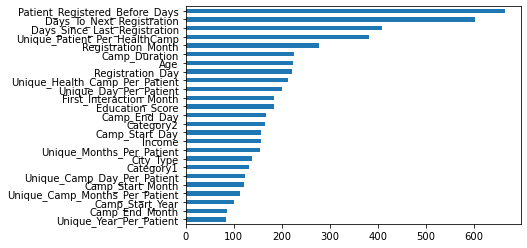

In [82]:
feature_importance_info = pd.Series(index = FEATURE_COLS, data = clf.feature_importances_)
feature_importance_info.sort_values(ascending=False)[0:25][::-1].plot(kind = 'barh', style = {'height': 100})

In [83]:
# Selecting top 25 important features
IMP_FEATURE_COLS = list(feature_importance_info.sort_values(ascending=False)[0:25].index)

In [84]:
X_train = trn[IMP_FEATURE_COLS]
X_test = val[IMP_FEATURE_COLS]

y_train = trn['Target']
y_test = val['Target']

<a id=section6></a>
# 6. Model building and prediction

<a id=section601></a>
## 6.1 LGBM Classifier

In [86]:
from sklearn.metrics import confusion_matrix, classification_report

lgbm = LGBMClassifier(n_estimators=450,learning_rate=0.03,random_state=1,colsample_bytree=0.5,reg_alpha=2,reg_lambda=2)
lgbm.fit(X_train, y_train)

lgbm_train_preds = lgbm.predict(X_train)
lgbm_test_preds = lgbm.predict(X_test)

print(confusion_matrix(y_train, lgbm_train_preds))
print(confusion_matrix(y_test, lgbm_test_preds))

print(classification_report(y_train, lgbm_train_preds))
print(classification_report(y_test, lgbm_test_preds))

[[31380  3187]
 [ 4348 10480]]
[[19462   715]
 [ 4114  1592]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     34567
           1       0.77      0.71      0.74     14828

   micro avg       0.85      0.85      0.85     49395
   macro avg       0.82      0.81      0.81     49395
weighted avg       0.84      0.85      0.85     49395

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     20177
           1       0.69      0.28      0.40      5706

   micro avg       0.81      0.81      0.81     25883
   macro avg       0.76      0.62      0.64     25883
weighted avg       0.80      0.81      0.78     25883



0.8142253404027008


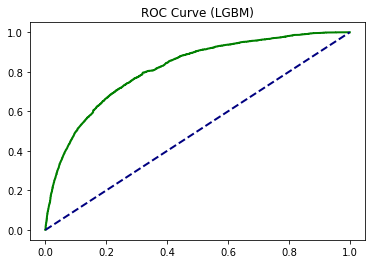

In [87]:
# ROC Curve for LGBM

fpr = dict()
tpr = dict()
roc_auc = dict()

y_pred_proba = lgbm.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr,tpr)
print(roc_auc)

plt.title("ROC Curve (LGBM)")
plt.plot(fpr, tpr, color='green',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

<a id=section602></a>
## 6.2 Final Prediction

In [88]:
lgbm_final_preds = lgbm.predict_proba(Test[IMP_FEATURE_COLS])[:,1]

In [90]:
final_preds = pd.DataFrame({"Patient_ID":Test['Patient_ID'].values})
final_preds["Health_Camp_ID"] = Test['Health_Camp_ID'].values
final_preds["Outcome"] =  lgbm_final_preds
final_preds.to_csv("final_preds.csv", index=False)